# Introduction to language-model-based data augmentation (LAMBADA)
https://arxiv.org/pdf/1911.03118.pdf

LAMBADA (Anaby-Tavor et al., 2019) is proposed to generate synthetic data. We follow the approach with modification into nlpaug so that we can generate more data with few lines of code. The following figures show steps of training LAMBADA. We will go through it step by step

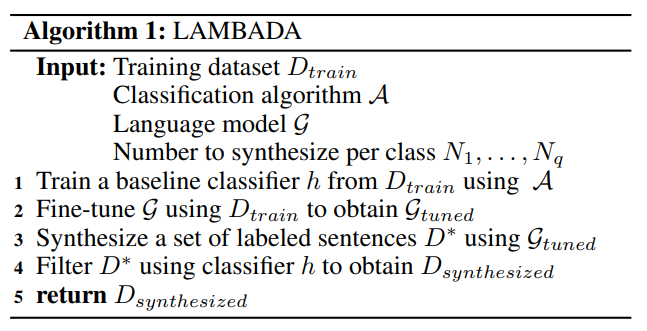

In [1]:
from IPython.display import Image
Image(filename='../res/lambada_algo.png')

# Step 0: Input Data
expected column name are "text" and "label"

In [2]:
import pandas as pd
data = pd.read_csv('../test/res/text/classification.csv')
data

,text,label
0,My hope lay in Jack's promise that he would ke...,LABEL_0
1,Dotty continued to go to Mrs. Gray's every nig...,LABEL_1
2,It was a bright and cheerful scene that greete...,LABEL_0
3,Cell division is the process by which a parent...,LABEL_2
4,Debugging is the process of finding and resolv...,LABEL_1
5,"To explain transitivity, let us look first at ...",LABEL_2
6,Milka and John are playing in the garden. Her ...,LABEL_2


# Step 1: Train the classifier

In [3]:
!python ../scripts/lambada/train_cls.py  \
    --train_data_path ../test/res/text/classification.csv \
    --val_data_path ../test/res/text/classification.csv \
    --output_dir ../model/lambada/cls \
    --device cuda \
    --num_epoch 2

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Traceback (most recent call last):
  File "../scripts/lambada/train_cls.py", line 79, in <module>
    main(args)
  File "../scripts/lambada/train_cls.py", line 55, in main
    baseline_estimator = make_baseline_estimator(args, train_data, val_data)
  File "../scripts/lambada/train_cls.py", line 18, in make_baseline_estimator
    model = ClassificationModel(
  File "/home/edward/anaconda3/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py", line 194, in __init__
    raise ValueError(
ValueError: 'use_cuda' set to True when cuda is unavailable. Make sure CUDA is available or set use_cuda=False.


# Step 2a: Processing data for task-adaptive pretraining

In [4]:
!python ../scripts/lambada/data_processing.py \
    --data_path ../test/res/text/classification.csv \
    --output_dir ../test/res/text

# Step 2b: Task-adpative pretraining for langauge model

In [5]:
!source activate py39; python ../scripts/lambada/run_clm.py \
    --tokenizer_name ../model/lambada/cls \
    --model_name_or_path gpt2 \
    --model_type gpt2 \
    --train_file ../test/res/text/mlm_data.txt \
    --output_dir ../model/lambada/gen \
    --do_train \
    --overwrite_output_dir \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --save_steps=10000 \
    --num_train_epochs 2

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
07/15/2021 22:52:26 - WARNING - __main__ -   Process rank: -1, device: cpu, n_gpu: 0distributed training: False, 16-bits training: False
07/15/2021 22:52:26 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=500,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
greater_is_better=None,
group_by_length=False,
ignore_data_skip=False,
label_names=None,
labe

# Step 3 ~ 5: Generate synthetic data

In [6]:
import nlpaug.augmenter.sentence as nas
aug = nas.LambadaAug(model_dir='../model/lambada', threshold=0.3, batch_size=4)

In [7]:
aug.augment(['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3'], n=10)

,id,text,label,pred,prob
10,10,The truth is shake hands with an assembly of...,LABEL_1,LABEL_1,0.9999
13,13,The first digital networks are imported from...,LABEL_1,LABEL_1,0.9999
15,15,The National Sleep bird on the River of the ...,LABEL_1,LABEL_1,0.9996
17,17,The reader may be heated to the lungs of coa...,LABEL_1,LABEL_1,0.9999
18,18,The journeyless blue and gives every indicat...,LABEL_1,LABEL_1,0.9999
19,19,The first magnitude Greeks is also disputed ...,LABEL_1,LABEL_1,0.9999
20,20,The molecules did not seem to notice any one...,LABEL_2,LABEL_2,1.0000
21,21,The first digital networks are mainly used f...,LABEL_2,LABEL_2,1.0000
23,23,The human heart was seldom very well. He was...,LABEL_2,LABEL_2,1.0000
26,26,The human body is vital for the first place ...,LABEL_2,LABEL_2,0.9998
